# Grammatical Error Correction Using Recurrent Neural Networks

## 1 - Business Problem

### 1.1 - Description

1 - Grammatical error correction is the task of automatically correcting grammatical errors in a text.                    
2 - Grammatical error correction system takes and erroneous sentence as input and is expected to find all the above errors transform the sentence into an error free sentence                                                                       
3 - Lets take an some examples to understand the problem better                                                    
Incorrect Sentence 1 - when You Are Go Smoothly , You Have To Be More Modest .                                           
Correct Sentence 1 - When Everything Is Going Smoothly , You Have To Be More Modest .                                       
Incorrect Sentence 2 - The Making Souvenir Is A Hard And Interesting Work .                                                   
Correct Sentence 2 - Making Souvenirs Is A Hard But Interesting Work .                                                  

### 1.2 Why this problem is important

1 - Native students as well as second language learners of a language can use a Grammatical error correction system as a writing
aid to help in their language learning journey an to improve their writing.                                                
2 - Sentence correction system can be utilised as a post editor for many applications like machine translation systems.     
3 - It can also be used inside a text editor to check writing for grammatical mistakes.

### 1.3 - Business objectives and constraints¶

1 - Strict latency constraints                                                                                         
2 - Interpretability is partially important

## 2 - Understanding the data

Dataset - Lang-8 Corpus of Learner English                                                                             

Data source - https://docs.google.com/forms/d/e/1FAIpQLSflRX3h5QYxegivjHN7SJ194OxZ4XN_7Rt0cNpR2YbmNV-7Ag/viewform              

Credits - Tomoya Mizumoto, Mamoru Komachi, Masaaki Nagata and Yuji Matsumoto.
Mining Revision Log of Language Learning SNS for Automated Japanese
Error Correction of Second Language Learners. In Proceedings of the
5th International Joint Conference on Natural Language Processing
(IJCNLP), pp.147-155. Chiang Mai, Thailand, November 2011.
and
Toshikazu Tajiri, Mamoru Komachi and Yuji Matsumoto. Tense and Aspect
Error Correction for ESL Learners Using Global Context. In Proceedings
of the 50th Annual Meeting of the Association for Computational
Linguistics: Short Papers (oral), pp.198-202. Jeju Island, Korea, July 2012.  

Data is given in the form of m2 file named lang8.train.auto.bea19.m2

In M2 format, a line followed by S denotes an original sentence while a line followed by A indicates an edit annotation
there are more than one annotations for an incorrect sentence

Example data format

S I heard a sentence last night when I watched TV .                                                                         
A 8 9|||R:VERB:TENSE|||was watching|||REQUIRED|||-NONE-|||0                                                                   
        
S We 've known each other for only half a year , but his lesson was a lot of fun .                                           
A 13 14|||R:NOUN:NUM|||lessons|||REQUIRED|||-NONE-|||0                                                                        
A 14 15|||R:VERB:SVA|||were|||REQUIRED|||-NONE-|||0                                                                          

size of lang8.train.auto.bea19.m2 file is 144 MB and this file contains 1037562 sentences

## 3 - Mapping Business Problem to a Machine learning problem

### 3.1 - Type of ML Problem

In this problem, input is a sequence of of in correct sentences while output is a sequence of correct grammatical sentence

So we can model this problem as a sequence to sequence learning problem

### 3.2 - Success Metric

Success Metric is the number of correct grammatical sentences generated by model.

If a model is able to rectify 90 - 95% or more sentences it will be considered a success, less than that will be a failure.

### 3.3 - Performence Metric

GLEU Score - To evaluate it, we take all sub-sequences 1, 2, 3 or 4 tokens in output and target sequence, and then          
compute a recall,and precision,GLEU score is simply the minimum of recall and precision. It ranges between 0 to 1

## 4 - Exploritory Data Analysis

### 4.1 - Importing necessary libraries

In [1]:
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import re
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense,RNN,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TimeDistributed
import numpy as np
from wordcloud import WordCloud,STOPWORDS
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
import pickle
import nltk.translate.bleu_score as bleu
from IPython.display import Image

In [2]:
#!wget --header="Host: doc-04-2g-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: AUTH_p1fg4b07u3raciih5atnsbt7sdk7uaqn=04473764286494136551|1616914050000|23ad1asnf8oakjb2cfh4ejacj0s984bm" --header="Connection: keep-alive" "https://doc-04-2g-docs.googleusercontent.com/docs/securesc/k57aefr9gh8rpf3r9srcg2pseasqmf46/f0lht4o09ndvr4q1q584j00kjcbj1pl1/1616914050000/04473764286494136551/04473764286494136551/18oxaQMyljG3wuIcLS0sHu7KSfUXoH3CP?e=download&authuser=0" -c -O 'gec1.zip'

In [3]:
#!unzip "gec1.zip"

### 4.2 - Converting data from m2 to csv file

In [ ]:
#code taken from https://www.cl.cam.ac.uk/research/nl/bea2019st/data/corr_from_m2.py

# Apply the edits of a single annotator to generate the corrected sentences.
def main():
    """
    this function stores the correct sentence line by line in as txt file with file name lang8.train.auto.bea19.m2
    """
    
    m2 = open("lang8.train.auto.bea19.m2").read().strip().split("\n\n")
    out = open("lang8.train.auto.bea19.txt", "w")
    # Do not apply edits with these error types
    skip = {"noop", "UNK", "Um"}
    
    for sent in m2:
        sent = sent.split("\n")
        cor_sent = sent[0].split()[1:] # Ignore "S "
        edits = sent[1:]
        offset = 0
        for edit in edits:
            edit = edit.split("|||")
            if edit[1] in skip: continue # Ignore certain edits
            coder = int(edit[-1])
            if coder != 0: continue # Ignore other coders
            span = edit[0].split()[1:] # Ignore "A "
            start = int(span[0])
            end = int(span[1])
            cor = edit[2].split()
            cor_sent[start+offset:end+offset] = cor
            offset = offset-(end-start)+len(cor)
        out.write(" ".join(cor_sent)+"\n")

In [ ]:
#preprocessing incorrect sentences

file1 = open("lang8.train.auto.bea19.m2","r")
s1 = file1.read()

each_sent = s1.split("\n\n")

incorrect = []
for i in range(len(each_sent)):
    temp = each_sent[i].split("\n")
    temp = temp[0]
    temp = temp.split(" ")
    temp = temp[1:]# ignore S
    temp = ' '.join(temp)
    incorrect.append(temp)

In [ ]:
#preprocessing correct sentences

file2 = open("lang8.train.auto.bea19.txt","r")
s2 = file2.read()

correct = s2.split("\n")

In [ ]:
# storing correct and incorrect sentence pair into dataframe
df = pd.DataFrame()
df["correct"] = correct
df["incorrect"] = incorrect

#store into csv file named data.csv
df.to_csv("data.csv",index=False)

In [ ]:
# reading data
df = pd.read_csv("data.csv")
df.head()

,correct,incorrect
0,Good luck on your new start !,Good luck on your new start !
1,My teacher is going to move to change his job .,My teacher is going to move to change his job .
2,He is a so nice guy and taught me English very...,He is a so nice guy and taught me English very...
3,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .
4,"Actually , he was the one who let me know abou...","Actually , who let me know about Lang - 8 was ..."


In [ ]:
print(df.shape)

(1037562, 2)


We can see that there are 1037562 pair of correct and incorrect sentences

### 4.3 - Analysing data and doing some simple data cleaning

We can see above that some of the pair of correct and incorrect sentences are same

So we should remove them

In [ ]:
index = []
for i in range(len(df.values)):
    if df.values[i][0] == df.values[i][1]:
        index.append(i)
            
df = df.drop(index)
df.shape

(498362, 2)

We can see that out of 1037562 data points only 498362 are left

In [ ]:
## save this new dataset to disk
#df.to_csv("new_data.csv",index=False)

In [2]:
df = pd.read_csv("new_data.csv")
df.head(2)

,correct,incorrect
0,And he took in my favorite subjects like soccer .,And he took in my favorite subject like soccer .
1,"Actually , he was the one who let me know abou...","Actually , who let me know about Lang - 8 was ..."


### 4.5 - Checking Missing Values

In [3]:
# ckeck if any missing value is present
df.isnull().values.any()

True

We can see that there are null values in pyton, So we will dop the rows containing null value

In [4]:
df.dropna(inplace=True)
df.shape

(498360, 2)

There were only two rows with null valued which have been deleted

### 4.6 - Checking for duplicates

In [5]:
# ckeck if any duplicate value is present
df.duplicated().values.any()

True

In [6]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)
df.shape

(496339, 2)

In [7]:
df.isnull().values.any()

False

There were 498360 - 496339 = 2021 duplicate rows which have been removed and only the first occurance of these rows ia kept.

### 4.7 - Data cleaning

In [8]:
def clean(text):
    """
    takes string as input and
    removes characters inside (),{},[] and <>
    removes characters like -+@#^/|*(){}$~`
    we not not removing ,.!-:;"' as these characters are present in english language 
    """
    text = re.sub('<.*>', '', text)
    text = re.sub('\(.*\)', '', text)
    text = re.sub('\[.*\]', '', text)
    text = re.sub('{.*}', '', text)
    text = re.sub("[-+@#^/|*(){}$~`<>=_]","",text)
    text = text.replace("\\","")
    text = re.sub("\[","",text)
    text = re.sub("\]","",text)
    text = re.sub("[0-9]","",text)
    return text

df["correct"] = df["correct"].apply(clean)
df["incorrect"] = df["incorrect"].apply(clean)

In [9]:
df.isnull().values.any()

False

### 4.8 Analyse length of correct sentences

In [10]:
def percentile(low,high,step,list_temp):
    """
    this function takes low, high, step size as input and prints percentiles accordingly
    """
    for i in np.arange(low,high,step):
        print(i,"percentile is ",np.percentile(list_temp ,i))

### at character level

In [ ]:
def sen_to_char(sen):
    return len([i for i in sen])

corr_length = df["correct"].apply(sen_to_char)
corr_length = list(corr_length)
len(corr_length)

496339

In [ ]:
percentile(0,101,10,corr_length)
print("***************************************************************")
percentile(90,101,1,corr_length)

0 percentile is  0.0
10 percentile is  27.0
20 percentile is  35.0
30 percentile is  42.0
40 percentile is  48.0
50 percentile is  55.0
60 percentile is  63.0
70 percentile is  73.0
80 percentile is  86.0
90 percentile is  108.0
100 percentile is  2622.0
***************************************************************
90 percentile is  108.0
91 percentile is  112.0
92 percentile is  116.0
93 percentile is  120.0
94 percentile is  125.0
95 percentile is  131.0
96 percentile is  139.0
97 percentile is  149.0
98 percentile is  163.0
99 percentile is  188.0
100 percentile is  2622.0


In [ ]:
# removing those data points which have correct sentence of length more than 108
index = []
for i in range(len(corr_length)):
    if corr_length[i] > 108:
        index.append(i)
        
df.drop(index,inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)

(446785, 2)


In [ ]:
df.isnull().values.any()

False

For incorrect sentences

In [ ]:
incorr_length = df["incorrect"].apply(sen_to_char)
incorr_length = list(incorr_length)
len(incorr_length)

446785

In [ ]:
percentile(0,101,10,incorr_length)
print("***********************************************************")
percentile(90,101,1,incorr_length)

0 percentile is  0.0
10 percentile is  25.0
20 percentile is  32.0
30 percentile is  38.0
40 percentile is  44.0
50 percentile is  50.0
60 percentile is  57.0
70 percentile is  64.0
80 percentile is  73.0
90 percentile is  85.0
100 percentile is  611.0
***********************************************************
90 percentile is  85.0
91 percentile is  87.0
92 percentile is  89.0
93 percentile is  91.0
94 percentile is  92.0
95 percentile is  95.0
96 percentile is  97.0
97 percentile is  99.0
98 percentile is  103.0
99 percentile is  107.0
100 percentile is  611.0


In [ ]:
# removing those data points which have incorrect sentence of length more than 108
index = []
for i in range(len(incorr_length)):
    if incorr_length[i] > 108:
        index.append(i)
        
df.drop(index,inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)

(443397, 2)


### at word level

In [12]:
corr_length = df["correct"].str.split().apply(len)
corr_length = list(corr_length)

In [13]:
percentile(0,101,10,corr_length)
print("***************************************************************")
percentile(90,101,1,corr_length)

0 percentile is  0.0
10 percentile is  6.0
20 percentile is  8.0
30 percentile is  9.0
40 percentile is  11.0
50 percentile is  12.0
60 percentile is  14.0
70 percentile is  16.0
80 percentile is  18.0
90 percentile is  23.0
100 percentile is  488.0
***************************************************************
90 percentile is  23.0
91 percentile is  23.0
92 percentile is  24.0
93 percentile is  25.0
94 percentile is  26.0
95 percentile is  27.0
96 percentile is  28.0
97 percentile is  30.0
98 percentile is  33.0
99 percentile is  38.0
100 percentile is  488.0


In [16]:
# removing those data points which have correct sentence of length more than 24
index = []
for i in range(len(corr_length)):
    if corr_length[i] > 24:
        index.append(i)
        
df.drop(index,inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)

(459812, 2)


In [18]:
incorr_length = df["incorrect"].str.split().apply(len)
incorr_length = list(incorr_length)

In [19]:
percentile(0,101,10,incorr_length)
print("***************************************************************")
percentile(90,101,1,incorr_length)

0 percentile is  0.0
10 percentile is  6.0
20 percentile is  7.0
30 percentile is  9.0
40 percentile is  10.0
50 percentile is  11.0
60 percentile is  12.0
70 percentile is  14.0
80 percentile is  16.0
90 percentile is  19.0
100 percentile is  128.0
***************************************************************
90 percentile is  19.0
91 percentile is  19.0
92 percentile is  20.0
93 percentile is  20.0
94 percentile is  20.0
95 percentile is  21.0
96 percentile is  22.0
97 percentile is  22.0
98 percentile is  23.0
99 percentile is  24.0
100 percentile is  128.0


In [20]:
# removing those data points which have incorrect sentence of length more than 25
index = []
for i in range(len(incorr_length)):
    if incorr_length[i] > 25:
        index.append(i)
        
df.drop(index,inplace=True)
df.reset_index(inplace=True,drop=True)
print(df.shape)

(458206, 2)


### 4.9 - Splitting data into train, CV and Test

In [21]:
train_temp,cv = train_test_split(df, test_size=0.1)
train,test = train_test_split(train_temp, test_size=0.1)

In [53]:
#store dataset into disk after splitting
train.to_csv("train_word.csv",index=False)
cv.to_csv("cv_word.csv",index=False)
test.to_csv("test_word.csv",index=False)

### 4.8 - Unique words in our dataset

In [4]:
# reading dataset
train = pd.read_csv("train_word.csv")
cv = pd.read_csv("cv_word.csv")
test = pd.read_csv("test_word.csv")

Unique words in Train dataset

In [31]:
# for incorrect sentences
split_sent = np.array(train["incorrect"].str.split())

unique = []
for i in split_sent:
    if type(i) == float:
        continue
    for j in i:
        unique.append(j)

unique_words_train_incorr = set(unique)
print("total number of unique words in incorrect sentences in train data are",len(unique_words_train_incorr))

total number of unique words in incorrect sentences in train data are 87564


In [32]:
# for correct sentences
split_sent = np.array(train["correct"].str.split())

unique = []
for i in split_sent:
    for j in i:
        unique.append(j)

unique_words_train_corr = set(unique)
print("total number of unique words in correct sentences in train are",len(unique_words_train_corr))

total number of unique words in correct sentences in train are 68105


Unique words in CV dataset

In [33]:
# for incorrect sentences
split_sent = np.array(cv["incorrect"].str.split())

unique = []
for i in split_sent:
    for j in i:
        unique.append(j)

unique_words_cv_incorr = set(unique)
print("total number of unique words in incorrect sentences in cv data are",len(unique_words_cv_incorr))

total number of unique words in incorrect sentences in cv data are 6300


In [34]:
# for correct sentences
split_sent = np.array(cv["correct"].str.split())

unique = []
for i in split_sent:
    for j in i:
        unique.append(j)

unique_words_cv_corr = set(unique)
print("total number of unique words in correct sentences in cv data are",len(unique_words_cv_corr))

total number of unique words in correct sentences in cv data are 5959


Unique words in Test dataset

In [38]:
# for incorrect sentences
split_sent = np.array(test["incorrect"].str.split())

unique = []
for i in split_sent:
    for j in i:
        unique.append(j)

unique_words_test_incorr = set(unique)
print("total number of unique words in incorrect sentences in test data are",len(unique_words_cv_incorr))

total number of unique words in incorrect sentences in test data are 6300


In [39]:
split_sent = np.array(test["incorrect"].str.split())

unique = []
for i in split_sent:
    for j in i:
        unique.append(j)

unique_words_test_corr = set(unique)
print("total number of unique words in correct sentences in test are",len(unique_words_test_corr))

total number of unique words in correct sentences in test are 6349


## 5 - Making data model ready

In [2]:
train = pd.read_csv("train.csv")
cv = pd.read_csv("cv.csv")
test = pd.read_csv("test.csv")

We will add $ to each sentence which will be input to decoder We will add @ to each sentence which will be output of decoder

In [4]:
train["correct_inp"] = "$" + train["correct"].astype(str)#$ denotes start of sentence
train["correct_out"] = train["correct"].astype(str) + "@"#@ denotes end of sentence

cv["correct_inp"] = "$" + cv["correct"].astype(str)
cv["correct_out"] = cv["correct"].astype(str) + "@"

In [6]:
# code reference https://stackoverflow.com/questions/45735070/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring
# loading saved tokenizer
with open("tokenizer_incorr.pickle","rb") as temp1:
    tokenizer_incorr = pickle.load(temp1)
    
with open("tokenizer_corr_inp.pickle","rb") as temp2:
    tokenizer_corr_inp = pickle.load(temp2)
    
with open("tokenizer_corr_out.pickle","rb") as temp3:
    tokenizer_corr_out = pickle.load(temp3)

Tokenizing senetence for feeding to encoder

In [7]:
# tokenizer_incorr = Tokenizer(filters="",char_level=True,lower=False)
#tokenizer_incorr.fit_on_texts(train["incorrect"].values)

incorr_train = np.array(tokenizer_incorr.texts_to_sequences(train["incorrect"].values))
incorr_cv = np.array(tokenizer_incorr.texts_to_sequences(cv["incorrect"].values))
print("vocab size of incorrrect sentences is",len(tokenizer_incorr.word_index))

vocab size of incorrrect sentences is 62


Tokenizing senetence for feeding to decoder as inpput



In [8]:
# tokenizer_corr_inp = Tokenizer(filters="",char_level=True,lower=False)
#tokenizer_corr_inp.fit_on_texts(train["correct_inp"].values)

corr_train_inp = np.array(tokenizer_corr_inp.texts_to_sequences(train["correct_inp"].values))
corr_cv_inp = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_inp"].values))
print("vocab size of corrrect sentences is",len(tokenizer_corr_inp.word_index))

vocab size of corrrect sentences is 63


Tokenizing senetence which will be output of decoder

In [9]:
#tokenizer_corr_out = Tokenizer(filters="",char_level=True,lower=False)
#tokenizer_corr_out.fit_on_texts(train["correct_out"].values)

corr_train_out = np.array(tokenizer_corr_out.texts_to_sequences(train["correct_out"].values))
corr_cv_out = np.array(tokenizer_corr_inp.texts_to_sequences(cv["correct_out"].values))

Padding train, cv, test data

In [10]:
incorr_train = np.array(pad_sequences(incorr_train,maxlen=110,padding="post",truncating='post'))
corr_train_inp = np.array(pad_sequences(corr_train_inp,maxlen=110,padding="post",truncating='post'))
corr_train_out = np.array(pad_sequences(corr_train_out,maxlen=110,padding="post",truncating='post'))

incorr_cv = np.array(pad_sequences(incorr_cv,maxlen=110,padding="post",truncating='post'))
corr_cv_inp = np.array(pad_sequences(corr_cv_inp,maxlen=110,padding="post",truncating='post'))
corr_cv_out = np.array(pad_sequences(corr_cv_out,maxlen=110,padding="post",truncating='post'))

In [11]:
##save keras tokenizer

# with open("tokenizer_incorr.pickle","wb") as temp1:
#     pickle.dump(tokenizer_incorr,temp1)
    
# with open("tokenizer_corr_inp.pickle","wb") as temp2:
#     pickle.dump(tokenizer_corr_inp,temp2)
    
# with open("tokenizer_corr_out.pickle","wb") as temp3:
#     pickle.dump(tokenizer_corr_out,temp3)

## Modelling

We will use a encoder decoder model as a basic model

In [13]:
# code taken from attention mechanism assignment

############################## Encoder class #############################################################
class Encoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,encoder_final_state_h,encoder_final_state_c
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=inp_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.encoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)


    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''

        output1 = self.embedding(input_sequence)
        enco_output, enco_state_h, enco_state_c = self.encoder_lstm(output1, initial_state=states)
        return enco_output, enco_state_h, enco_state_c

    
    def initialize_states(self,batch_size):

        initial_hidden_state = tf.zeros([batch_size,self.lstm_size])
        initial_cell_state = tf.zeros([batch_size,self.lstm_size])
        
        return [initial_hidden_state,initial_cell_state]

############################## Decoder class #############################################################
class Decoder(tf.keras.layers.Layer):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):

        super().__init__()
        self.lstm_size = lstm_size
        self.embedding = Embedding(input_dim=out_vocab_size, output_dim=embedding_size, input_length=input_length,
                           mask_zero=True,name="embedding_layer_encoder")
        self.lstmcell = tf.keras.layers.LSTMCell(lstm_size)
        self.decoder_lstm = RNN(self.lstmcell,return_sequences=True, return_state=True)

    def call(self,target_sequence,initial_states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
          returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''
        output2 = self.embedding(target_sequence)
        deco_output, deco_state_h, deco_state_c = self.decoder_lstm(output2, initial_state=initial_states)
      
        return deco_output, deco_state_h, deco_state_c

##############################encoder decoder class#############################################################    
    
qw_state = 0
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,inp_vocab_size,out_vocab_size,embedding_size,lstm_size,input_length,batch_size,*args):
        
        super().__init__()
        self.encoder = Encoder(inp_vocab_size,embedding_size,lstm_size,input_length)
        #print("output vocab size in encoder decoder class",out_vocab_size)
        self.decoder = Decoder(out_vocab_size,embedding_size,lstm_size,input_length)
        self.dense   = Dense(out_vocab_size)#, activation='softmax')
        self.batch = batch_size
    
    
    def call(self,data,*args):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        
        input,output = data[0], data[1]
        # initializing initial states of encoder
        l = self.encoder.initialize_states(self.batch)
        qw_state = l
        #print("WE ARE INITIALIZING encoder WITH initial STATES as zeroes :",l[0].shape, l[1].shape)
        #print("hello")
        encoder_output,encoder_final_state_h,encoder_final_state_c = self.encoder(input,l)
        #print("ENCODER ==> OUTPUT SHAPE",encoder_output.shape)
        #print("ENCODER ==> HIDDEN STATE SHAPE",encoder_final_state_h.shape)
        #print("ENCODER ==> CELL STATE SHAPE", encoder_final_state_c.shape)
        #print("hi")
        m = list((encoder_final_state_h,encoder_final_state_c))
        decoder_output,decoder_final_state_h,decoder_final_state_c = self.decoder(output,m)
        #print("decoder OUTPUT SHAPE",decoder_output.shape)
        #print("type of decoder output is ",type(decoder_output))
        #x = self.flatten(decoder_output)
        #print("shape of x ",x.shape)
        qw_output = self.dense(decoder_output)
        #print("FINAL OUTPUT SHAPE",qw_output.shape)
        return qw_output

#### Encoder Decoder Model with character embedding

In [14]:
inp_vocab_size = 63
out_vocab_size = 64
embedding_dim=100
input_length=110
lstm_size=256
batch_size=1024
#model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)
# custom loss function
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
#defining custom loss function which will not consider loss for padded zeroes
# code taken from attention assignment
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
#model.compile(optimizer=optimizer,loss=loss_function)

In [ ]:
#Load the TensorBoard notebook extension
import datetime
%load_ext tensorboard
!rm -rf ./logs/

Train the model

In [20]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(x=[incorr_train,corr_train_inp],y=corr_train_out, epochs=10,batch_size=1024,callbacks=[tensorboard_callback],validation_data=([incorr_train_cv,corr_cv_inp],corr_cv_out))
#model.fit(x=[temp1,temp2],y=temp3, epochs=1,batch_size=1024)

Epoch 1/25
384/384 [==============================] - 194s 492ms/step - loss: 0.6976
Epoch 2/25
384/384 [==============================] - 187s 486ms/step - loss: 0.4391
Epoch 3/25
384/384 [==============================] - 187s 486ms/step - loss: 0.3616
Epoch 4/25
384/384 [==============================] - 187s 486ms/step - loss: 0.3217
Epoch 5/25
384/384 [==============================] - 187s 486ms/step - loss: 0.2987
Epoch 6/25
384/384 [==============================] - 187s 487ms/step - loss: 0.2815
Epoch 7/25
384/384 [==============================] - 187s 486ms/step - loss: 0.2652
Epoch 8/25
384/384 [==============================] - 187s 487ms/step - loss: 0.2514
Epoch 9/25
384/384 [==============================] - 187s 486ms/step - loss: 0.2391
Epoch 10/25
384/384 [==============================] - 187s 486ms/step - loss: 0.2288
Epoch 11/25
384/384 [==============================] - 187s 486ms/step - loss: 0.2210
Epoch 12/25
384/384 [==============================] - 187s 487

In [22]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  371868    
_________________________________________________________________
decoder (Decoder)            multiple                  371968    
_________________________________________________________________
dense (Dense)                multiple                  16448     
Total params: 760,284
Trainable params: 760,284
Non-trainable params: 0
_________________________________________________________________


In [38]:
#%tensorboard --logdir logs/fit

In [15]:
# code taken from https://colab.research.google.com/drive/172D4jishSgE3N7AO6U2OKAA_0wNnrMOq#scrollTo=mJqOn0snzCRy
#model.save_weights('enco_dec_char', save_format='tf')

model = Encoder_decoder(inp_vocab_size,out_vocab_size,embedding_dim,lstm_size,input_length,batch_size)
model.compile(optimizer=optimizer,loss=loss_function)
model.train_on_batch([incorr_train[:1024],corr_train_inp[:1024]],corr_train_out[:1024])
# Load the state of the old model
model.load_weights('enco_dec_char')

In [17]:
#code taken from attention mechanism assignment
corr_dict = tokenizer_corr_out.word_index
inv_corr = {v: k for k, v in corr_dict.items()}

def predict(input_sentence):
    """
    this function takes incorrect input sentences s input and retirns correct sentences
    """
    input_sentence = tokenizer_incorr.texts_to_sequences([input_sentence])
    initial_hidden_state = tf.zeros([1,256])
    initial_cell_state = tf.zeros([1,256])
    qwst = [initial_hidden_state,initial_cell_state]
    pred_total = []
    enc_output, enc_state_h, enc_state_c = model.layers[0](np.expand_dims(input_sentence[0],0),qwst)
    states_values = [enc_state_h, enc_state_c]
    pred = []
    sentence = []
    cur_vec = np.array([[16]])#np.ones((1, 1),dtype='int')
    for i in range(110):
        dec_output, dec_state_h, dec_state_c = model.layers[1](cur_vec,states_values)
        infe_output=model.layers[2](dec_output)
        states_values = [dec_state_h, dec_state_c]
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        if inv_corr[cur_vec[0][0]] == '@':
            break
            #print("at time step ",i," the word is ", cur_vec)
        pred.append(cur_vec[0][0])
    for i in pred:
        sentence.append(inv_corr[i])
    #return pred
    return "".join(sentence)

#### GLUE Score on test data

In [21]:
from nltk.translate.gleu_score import sentence_gleu

gleu_score_test = 0
length = 1000

for i in range(length):
    reference = [test["correct"].values[i:i+1][0].split()]
    candidate = predict(test["incorrect"].values[i:i+1][0]).split()
    gleu_score_test = gleu_score_test + sentence_gleu(reference, candidate)
print("Final GLEU Score on Test data are",gleu_score_test/length)

Final GLEU Score on Test data are 0.2176001391901613


Prediting results on train data

In [17]:
#predicted sentences
for i in train["incorrect"].values[:10]:
  print(predict(i))

I love very much , which is one of the Dariso .
Sell Gimera , and so on .
Nowadays I have to find the student for a restaurant to learn .
It is one of the most famous and many .
I would like to learn English , but I will try to learn .
Just this writing this website .
Then I put them on the other .
The weather is nice but we are planning to move to the station .
I 'm option and I could n't go to the United early , I feel happy .
She never been in a box , I had a content .


In [25]:
#actual sentences
train["correct"].values[:10]

array(["I love it very much when I am in Odessa . It 's raining .",
       'Selena Gomez sings it .',
       'Nowadays I take a fresh interest in studying a foreign language .',
       'It is one of my most favorite manga .',
       'I would like to learn English because I want to travel .',
       'Just trying this website .', 'then I put them into the oven .',
       'The weather is nice but we are planning to move out of this state .',
       "I 'm bad at English but I try the challenge  but I challenge myself until I feel I 've have enough .",
       'She envies me because in Bangkok I feel hot .'], dtype=object)

Prediting results on cv data

In [15]:
#predicted sentences
for i in cv["incorrect"].values[:10]:
  print(predict(i))

It made my home since I can help .
All the google we came back to the light on the child .
Touring football .
Anyway , the only the teacher for the best , I want to go to Ling   by TV program .
And the number of being are conversations in the lunch .
My name is Nakuro 
As my friends , too ,
Recently I realized that the couple of this site .
There are lots of clothes and short more .
In the weather , to walk about what happened .


In [26]:
#actual sentences
cv["correct"].values[:10]

array(["It made me happy because I 'm a chocoholic .",
       "All the things goes well before  o ' clock this night . tense",
       'Football Tournament',
       'Anyway , the Beatles song that I like best is  The Long and Winding Road . ',
       'And the number of believers are constantly on the rise .',
       'My name is Jae yong han .', 'As my friends told me ,',
       'Recently a few things have come to my attention .',
       'There are lots of clothes and shoes in my room .',
       'We talked about what we call happiness .'], dtype=object)

prediction on test data

In [19]:
#predicted sentences
for i in test["incorrect"].values[:10]:
  print(predict(i))

Maybe it is completely .
There are a lot of playing ball .
that was a junior as a short .
I 'm going to visit !
Although the movie , the teacher at my Part , speaking , looks like Mr . . 
I know that I can not start my life because I have to be able to remember that he wants to understand what peo
The content of the friends will be happy because of the other country .
But I 'm interested in another picture .
I have a lot of place to go to China to study english for the hotel  .
Some class and term to go to the game , but they decided to study and participate .


In [20]:
#actual sentences
test["correct"].values[:10]

array(['Maybe it was caused by pollen .',
       'There are a lot of outlet plazas .',
       'that was just an astonishing sight ,', 'I would never give up !',
       'Although , my teacher said ,  Maria , please play more speedily .  ,',
       'I know that I still can not relax my attention but I feel happy because we both are healthy now .',
       'The contents were frozen foods which had been cooked by her .',
       "But I 'm trying to find important information . ? ?",
       'I plan to go to a junior high school to teach science on   th of Dec .',
       'Some classmates got together , and decided to make a study group .'],
      dtype=object)

#### Plotting tensorboard plots¶

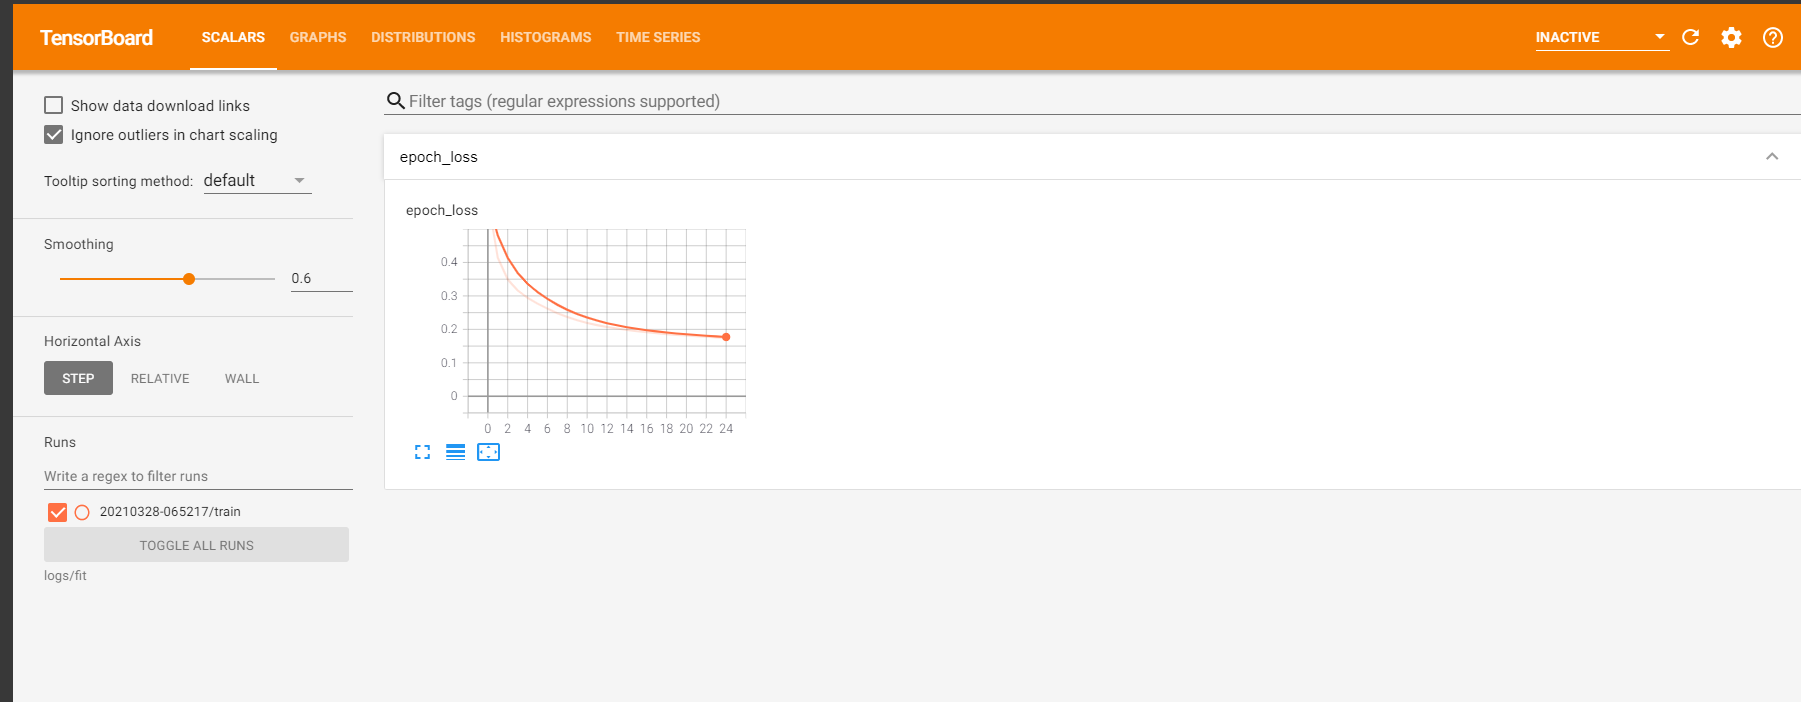

In [54]:
Image(filename='encoder_decoder_char_1.png')

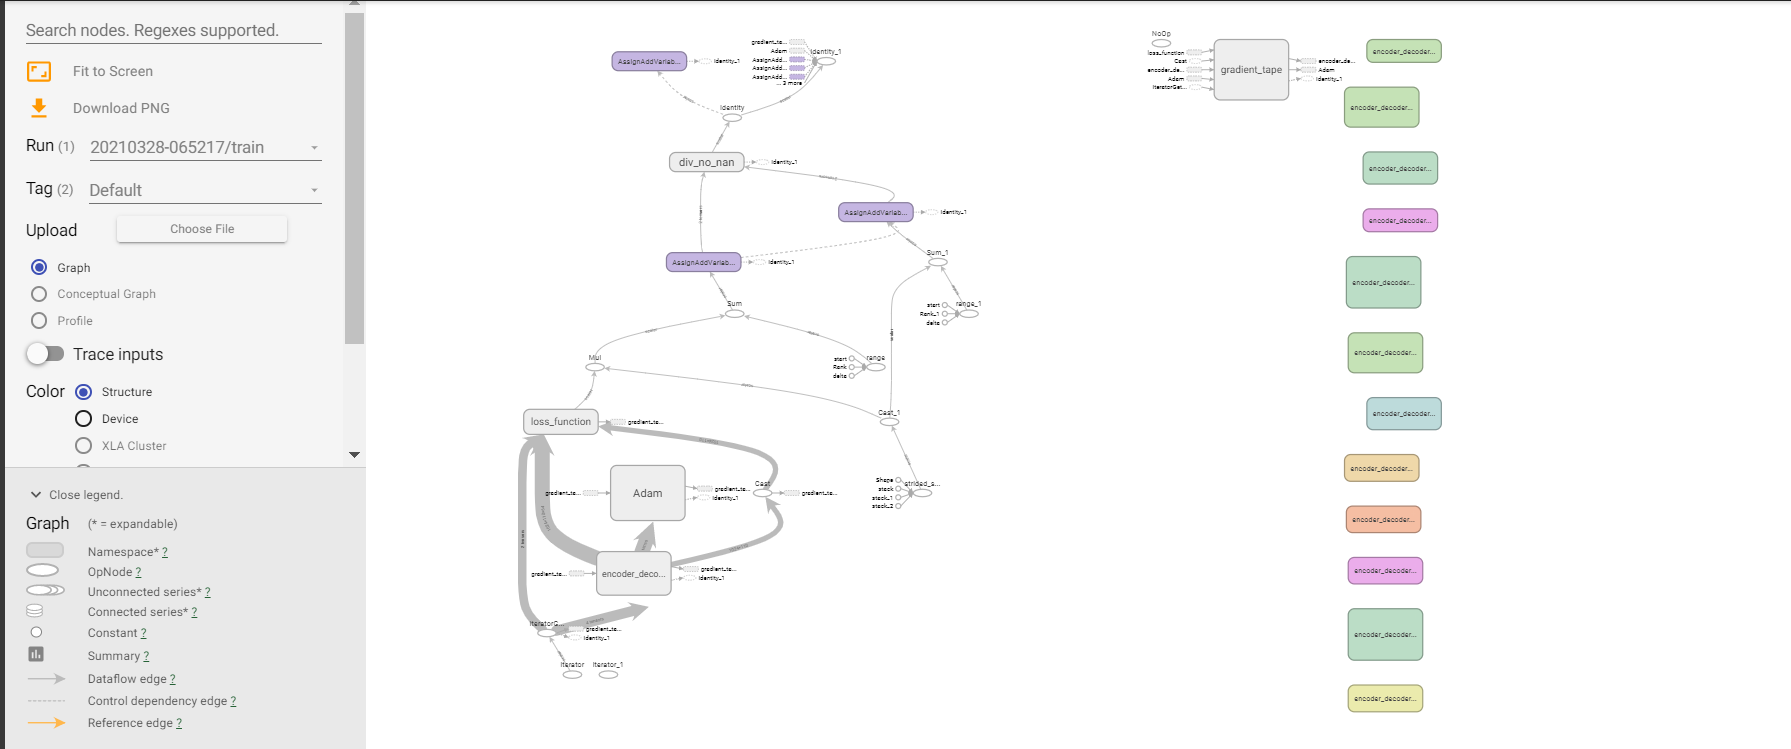

In [55]:
Image(filename='encoder_decoder_char_2.png')

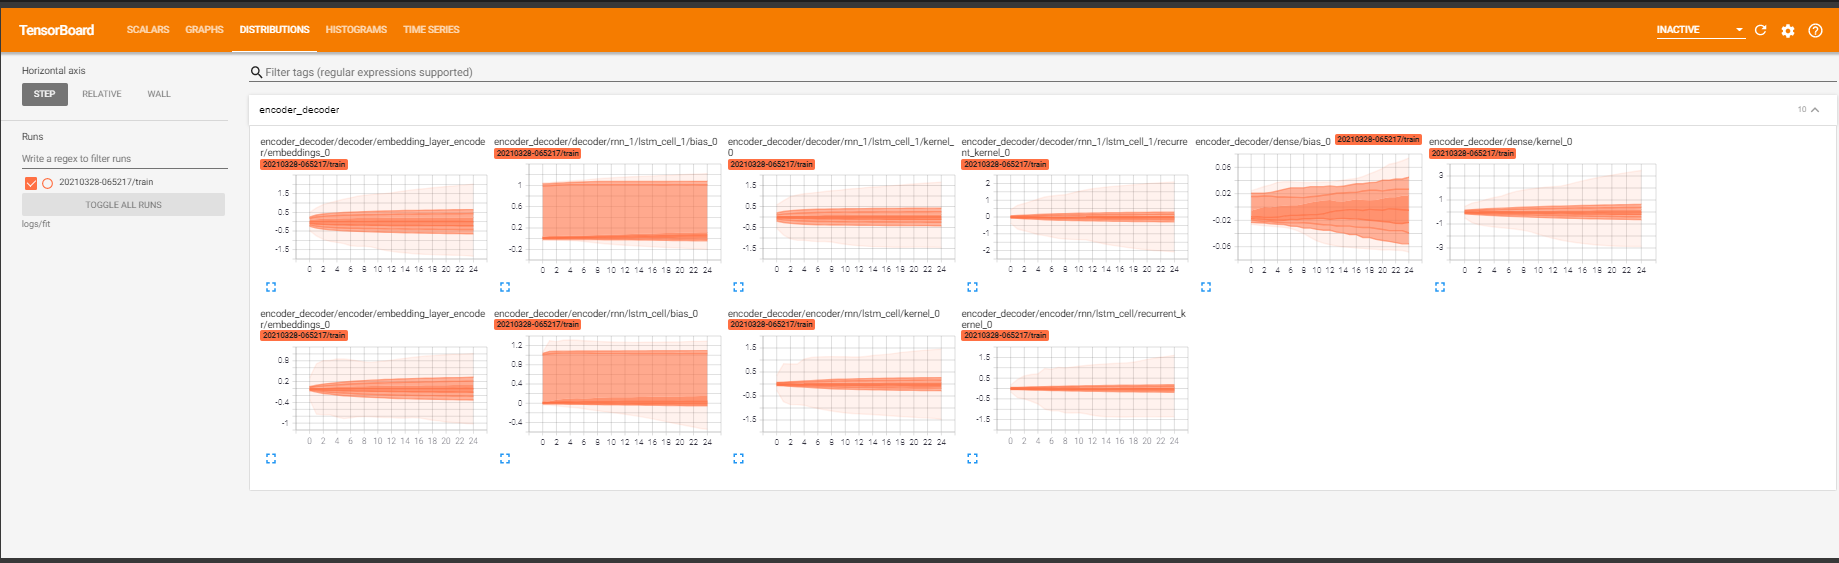

In [56]:
Image(filename='encoder_decoder_char_3.png')

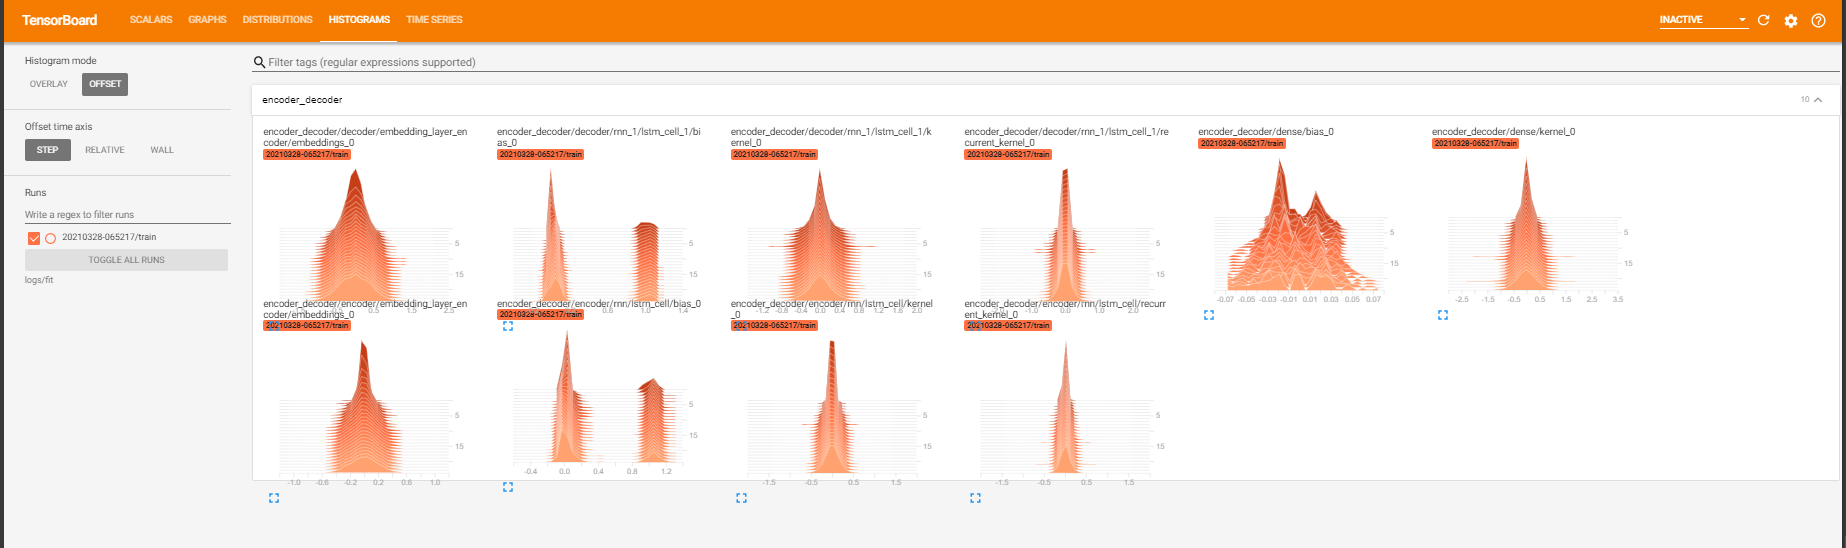

In [57]:
Image(filename='encoder_decoder_char_4.png')